In [61]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

In [10]:
torch.cuda.set_device(1)

In [15]:
faces = Path("./datasets/faces")
(faces).ls()

(#16738) [Path('datasets/faces/51_hola_papa_1_43751.jpg'),Path('datasets/faces/24_puercoespin_perro_1_47084.jpg'),Path('datasets/faces/27_hola_gato_1_10777.jpg'),Path('datasets/faces/25_hola_papa_0_29027.jpg'),Path('datasets/faces/25_hola_perro_1_45177.jpg'),Path('datasets/faces/36_adios_gato_1_53042.jpg'),Path('datasets/faces/66_adios_perro_1_67449.jpg'),Path('datasets/faces/39_puercoespin_gato_0_07859.jpg'),Path('datasets/faces/21_hola_papa_0_52079.jpg'),Path('datasets/faces/42_adios_papa_0_18844.jpg'),Path('datasets/faces/8_adios_mama_1_24214.jpg'),Path('datasets/faces/25_adios_perro_1_62780.jpg'),Path('datasets/faces/18_hola_perro_1_25028.jpg'),Path('datasets/faces/45_puercoespin_mama_1_28241.jpg'),Path('datasets/faces/17_hola_gato_1_20604.jpg'),Path('datasets/faces/56_hola_mama_0_22034.jpg'),Path('datasets/faces/18_hola_mama_1_43878.jpg'),Path('datasets/faces/30_puercoespin_perro_0_13483.jpg'),Path('datasets/faces/31_puercoespin_mama_1_54033.jpg'),Path('datasets/faces/50_puercoesp

In [53]:
def get_labels(route):

    if hasattr(route, 'name'):
        name = route.name
    else:
        # Si no, asumimos que ya es un string (texto)
        name = str(route)

    pieces = name.split('_') 

    try:
        age = float(pieces[0])
        first_category = str(pieces[1])
        second_category = str(pieces[2])
    except:
        return 0.0, "error", "error"

    return age, first_category, second_category

In [20]:
ruta_prueba = Path('datasets/faces/51_hola_papa_1_43751.jpg')
print(get_labels(ruta_prueba))

(51, 'hola', 'papa')


In [30]:
cat1_uniques = set()
cat2_uniques = set()

for face in (faces).ls():
    try:

        age, c1, c2 = get_labels(face)
        cat1_uniques.add(c1)
        cat2_uniques.add(c2)

    except:
        print(f"Fail with file: {face.name}")

print(f"Category 1: {len(cat1_uniques)} are unique. Are: {cat1_uniques}")
print(f"Category 2: {len(cat2_uniques)} are unique. Are: {cat2_uniques}")

Category 1: 3 are unique. Are: {'puercoespin', 'adios', 'hola'}
Category 2: 4 are unique. Are: {'mama', 'papa', 'gato', 'perro'}


In [36]:
class Multi_Classification_Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet18(pretrained=True)

        n_inputs = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        self.age = nn.Linear(n_inputs, 1)
        self.cat1 = nn.Linear(n_inputs, 3)
        self.cat2 = nn.Linear(n_inputs, 4)

    def forward(self, x):

        features = self.backbone(x)

        pred_age = self.age(features)
        pred_cat1 = self.cat1(features)
        pred_cat2 = self.cat2(features)

        return pred_age, pred_cat1, pred_cat2


In [58]:
class Loss_Func(nn.Module):
    def __init__(self):
        super().__init__()

        self.loss_age = nn.MSELoss()
        self.loss_cat = nn.CrossEntropyLoss()

    def forward(self, preds, targets):
        pred_age, pred_cat1, pred_cat2 = preds
        target_age, target_cat1, target_cat2 = targets

        error_1 = self.loss_age(pred_age.squeeze(), target_age)
        error_2 = self.loss_cat(pred_cat1, target_cat1)
        error_3 = self.loss_cat(pred_cat2, target_cat2)

        total_loss = error_1 + error_2 + error_3

        return total_loss

In [40]:
map_cat1 = {word: i for i, word in enumerate(sorted(cat1_uniques))}
map_cat2 = {word: i for i, word in enumerate(sorted(cat2_uniques))}

In [44]:
tfms = T.Compose([
    T.Resize((224, 224)),  # 1. Redimensionar al tamaño que espera la ResNet
    T.ToTensor(),         
    T.Normalize(           # 2. NORMALIZACIÓN DE IMAGEN (Estándar de ImageNet)
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

In [51]:
class UTKDataset(Dataset):
    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # 1. Localizar el archivo
        route = Path(self.files[idx])
        
        # 2. Abrir la imagen y convertirla a Tensor
        img = Image.open(route).convert('RGB')
        if self.transform:
            img = self.transform(img)
            
        # 3. EXTRAER LAS ETIQUETAS 
        
        age, c1, c2 = get_labels(route)
        idx_cat1 = map_cat1.get(c1, 0)
        idx_cat2 = map_cat2.get(c2, 0)
        
        # 4. Empaquetar (Devolvemos: Imagen, Tupla de Etiquetas)
        # Edad -> float32
        # Categorías -> long (enteros)
        
        labels = (
            torch.tensor(age/100, dtype=torch.float32),
            torch.tensor(idx_cat1, dtype=torch.long),
            torch.tensor(idx_cat2, dtype=torch.long)
        )
        
        return img, labels

In [54]:
full_dataset = UTKDataset((faces).ls(), transform=tfms)

train_size = int(0.8 * len(full_dataset))
valid_size = len(full_dataset) - train_size
train_ds, valid_ds = random_split(full_dataset, [train_size, valid_size])

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True)

In [55]:
# Sacamos un lote del cargador
imgs, labels = next(iter(train_dl))
ages, cats1, cats2 = labels

print("Forma de las imágenes:", imgs.shape) 
# Debería decir: torch.Size([32, 3, 224, 224])

print("Forma de las edades:", ages.shape)
# Debería decir: torch.Size([32]) o [32, 1]

print("Ejemplo de edad normalizada:", ages[0].item())
# Debería ser un número tipo 0.25 (25 años)

Forma de las imágenes: torch.Size([32, 3, 224, 224])
Forma de las edades: torch.Size([32])
Ejemplo de edad normalizada: 0.36000001430511475


In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Multi_Classification_Regression().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = Loss_Func()

num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_dl):
        images = images.to(device)
        targets = (labels[0].to(device), labels[1].to(device), labels[2].to(device))

        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, targets)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        if i % 10 == 0:
            print(f"Epoch {epoch}, lote {i}, Loss: {loss.item():.4f}")

/home/paquito/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/paquito/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0, lote 0, Loss: 3.5717
Epoch 0, lote 10, Loss: 2.7019
Epoch 0, lote 20, Loss: 2.5076
Epoch 0, lote 30, Loss: 2.2684
Epoch 0, lote 40, Loss: 2.1966
Epoch 0, lote 50, Loss: 2.0475
Epoch 0, lote 60, Loss: 2.0460
Epoch 0, lote 70, Loss: 1.9724
Epoch 0, lote 80, Loss: 1.9700
Epoch 0, lote 90, Loss: 1.7701
Epoch 0, lote 100, Loss: 1.8554
Epoch 0, lote 110, Loss: 1.7340
Epoch 0, lote 120, Loss: 2.2604
Epoch 0, lote 130, Loss: 2.0741
Epoch 0, lote 140, Loss: 1.4796
Epoch 0, lote 150, Loss: 1.5498
Epoch 0, lote 160, Loss: 1.8289
Epoch 0, lote 170, Loss: 1.4387
Epoch 0, lote 180, Loss: 1.3016
Epoch 0, lote 190, Loss: 1.5114
Epoch 0, lote 200, Loss: 1.3737
Epoch 0, lote 210, Loss: 1.4115
Epoch 0, lote 220, Loss: 1.4964
Epoch 0, lote 230, Loss: 1.0575
Epoch 0, lote 240, Loss: 0.7598
Epoch 0, lote 250, Loss: 0.8967
Epoch 0, lote 260, Loss: 0.6670
Epoch 0, lote 270, Loss: 1.0910
Epoch 0, lote 280, Loss: 0.4011
Epoch 0, lote 290, Loss: 1.3730
Epoch 0, lote 300, Loss: 1.0144
Epoch 0, lote 310, 

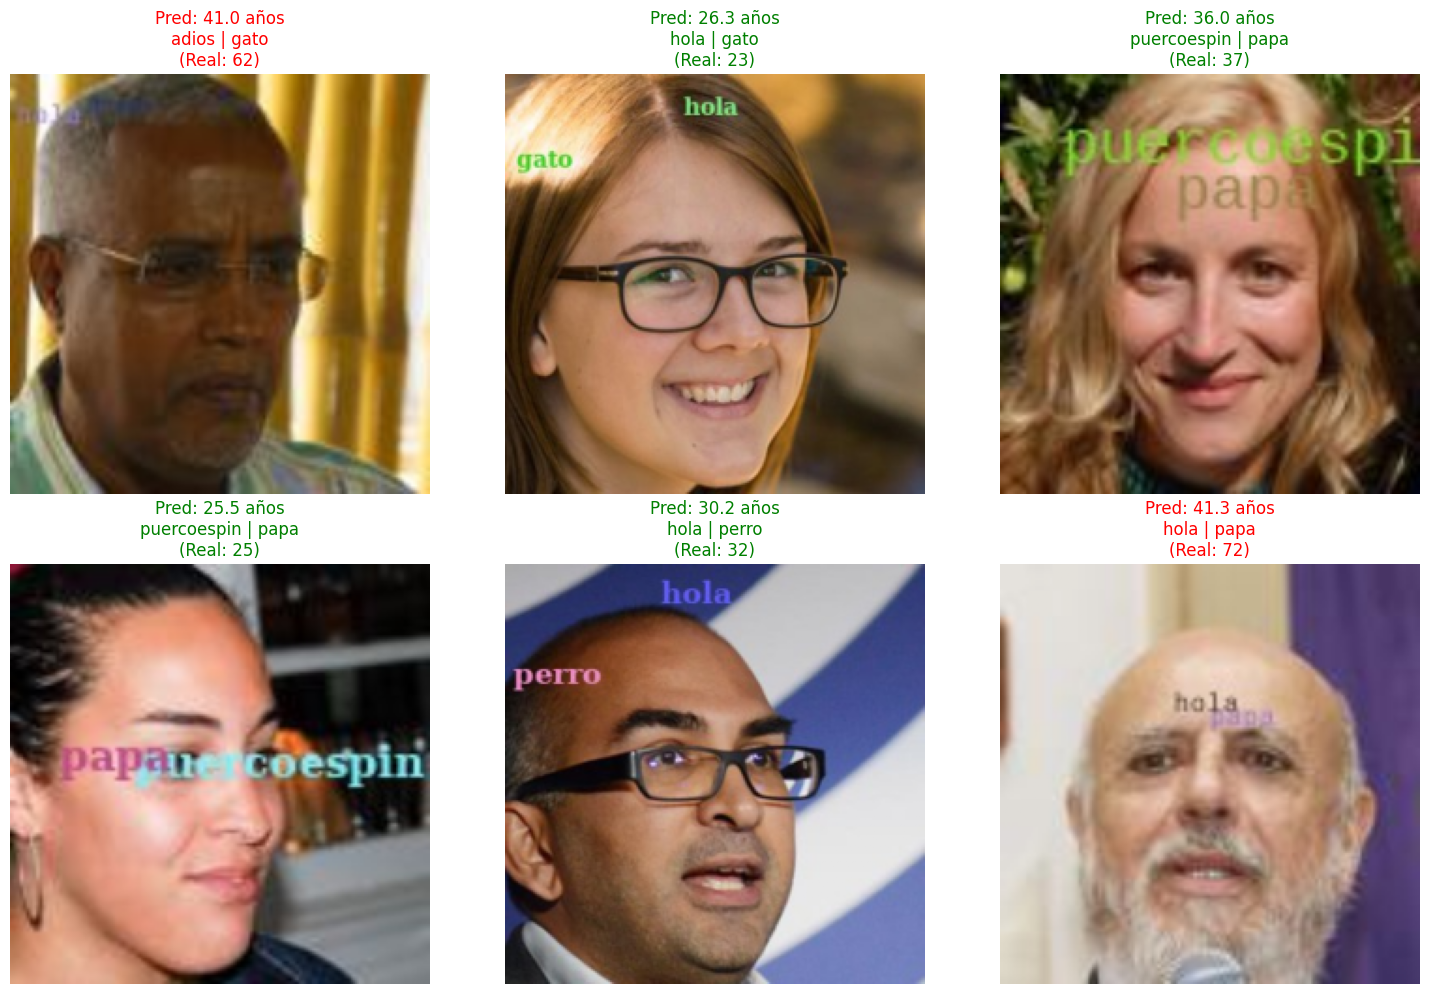

In [62]:
# 1. Invertimos los diccionarios para poder traducir de Números a Palabras
# (De { 'hola': 0 } pasamos a { 0: 'hola' })
idx_to_cat1 = {v: k for k, v in map_cat1.items()}
idx_to_cat2 = {v: k for k, v in map_cat2.items()}

def visualizar_resultados(model, loader, num_imgs=6):
    model.eval() # ¡IMPORTANTE! Pone la red en modo examen (apaga Dropout, congela Batchnorm)
    
    # Traemos un lote
    imgs, labels = next(iter(loader))
    
    # Movemos a GPU
    imgs = imgs.to(device)
    
    # Predecimos (Sin calcular gradientes para ahorrar memoria)
    with torch.no_grad():
        preds = model(imgs)
    
    # Desempaquetamos predicciones
    p_edades, p_cat1, p_cat2 = preds
    
    # Preparamos gráfica
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i in range(num_imgs):
        ax = axes[i]
        
        # --- PROCESAR IMAGEN ---
        # Las imágenes están normalizadas (colores raros), hay que des-normalizar para verlas bien
        img_cpu = imgs[i].cpu().permute(1, 2, 0) # De (C,H,W) a (H,W,C)
        # Truco rápido para desnormalizar visualmente:
        img_cpu = img_cpu * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img_cpu = torch.clamp(img_cpu, 0, 1) # Asegurar que estén entre 0 y 1
        
        ax.imshow(img_cpu)
        
        # --- PROCESAR PREDICCIONES ---
        # Edad: Deshacemos la división entre 100
        # (Si usaste Sigmoid, recuerda que la salida está entre 0 y 1, así que *100 funciona)
        pred_edad_num = p_edades[i].item() * 100
        real_edad_num = labels[0][i].item() * 100
        
        # Categorías: Buscamos el índice con mayor probabilidad (argmax)
        pred_c1_idx = torch.argmax(p_cat1[i]).item()
        pred_c2_idx = torch.argmax(p_cat2[i]).item()
        
        # Traducimos a texto
        txt_c1 = idx_to_cat1.get(pred_c1_idx, "Desc")
        txt_c2 = idx_to_cat2.get(pred_c2_idx, "Desc")
        
        # Título: PREDICCIÓN vs (REAL)
        ax.set_title(f"Pred: {pred_edad_num:.1f} años\n{txt_c1} | {txt_c2}\n(Real: {real_edad_num:.0f})", 
                     color=("green" if abs(pred_edad_num - real_edad_num) < 5 else "red"))
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# ¡Llamamos a la función!
visualizar_resultados(model, valid_dl)

In [ ]:
# --- Función hecha con IA ---
def evaluar_metricas(model, loader):
    model.eval() # Modo evaluación
    
    # Contadores
    total_error_edad = 0.0
    aciertos_cat1 = 0
    aciertos_cat2 = 0
    total_muestras = 0
    
    print("Iniciando evaluación del conjunto de validación...")
    
    with torch.no_grad():
        for images, labels in loader:
            # 1. Mover a GPU
            images = images.to(device)
            target_edad = labels[0].to(device)
            target_cat1 = labels[1].to(device)
            target_cat2 = labels[2].to(device)
            
            # 2. Predecir
            pred_edad, pred_cat1, pred_cat2 = model(images)
            
            # --- CÁLCULO DE EDAD ---
            edad_real_predicha = pred_edad.squeeze() * 100
            edad_real_objetivo = target_edad * 100
            total_error_edad += torch.abs(edad_real_predicha - edad_real_objetivo).sum().item()
            
            # --- CÁLCULO DE CATEGORÍAS ---
            _, predicted_c1 = torch.max(pred_cat1, 1)
            _, predicted_c2 = torch.max(pred_cat2, 1)
            
            aciertos_cat1 += (predicted_c1 == target_cat1).sum().item()
            aciertos_cat2 += (predicted_c2 == target_cat2).sum().item()
            
            total_muestras += images.size(0)
    
    # --- RESULTADOS FINALES ---
    mae_final = total_error_edad / total_muestras
    acc_cat1 = 100 * aciertos_cat1 / total_muestras
    acc_cat2 = 100 * aciertos_cat2 / total_muestras
    
    # --- REPORTE NARRATIVO ---
    print("\nResumen de rendimiento del modelo:")
    print(f"Al intentar predecir la edad, el modelo tiene un error promedio de {mae_final:.2f} años.")
    print(f"Para la primera categoría de texto, logró clasificar correctamente el {acc_cat1:.1f}% de las imágenes.")
    print(f"En la segunda categoría, obtuvo una exactitud del {acc_cat2:.1f}%.")

# Ejecutar reporte
evaluar_metricas(model, valid_dl)

Iniciando evaluación del conjunto de validación...

Resumen de rendimiento del modelo:
Al intentar predecir la edad, el modelo tiene un error promedio de 9.98 años.
Para la primera categoría de texto, logró clasificar correctamente el 96.2% de las imágenes.
En la segunda categoría, obtuvo una exactitud del 92.1%.


In [65]:
torch.save(model.state_dict(), "./Tareas/Multi_Reg.pth")